In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/date_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip


In [ ]:
!ls ../input/recruit-restaurant-visitor-forecasting -al

- 참고자료: [unzip file not matched 오류가 나는 이유](https://sancs.tistory.com/5)

In [ ]:
!unzip ../input/recruit-restaurant-visitor-forecasting/\*.zip

# 🤔 그 날, 얼마나 많은 사람들이 우리 가게에 올까 ?

# DATA: [Recruit Restaurant Visitor Forecasting Data](https://www.kaggle.com/anvesh525/recruit-restaurant-visitor-forecasting-data)
기존의 데이터(AIR, HPG, 연결)와 추가 데이터(Weather)가 있다.
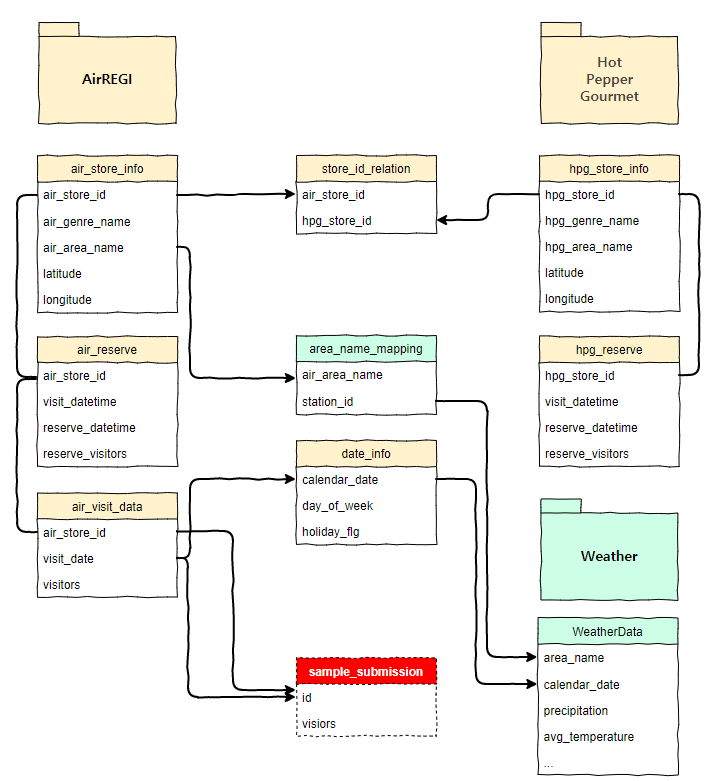
- 기존의 데이터: air사이트와 hpg사이트로 부터 얻은 두 부류의 데이터가 주어진다.
  - air 데이터
    - air_reserve.csv
    - air_store_info.csv
    - air_visit_data.csv
  - hpg 데이터
    - hpg_reserve.csv
    - hpg_store_info.csv
  - 연결 데이터
    - store_id_relation.csv
  - 기타 데이터
    - date_info.csv


 - 추가 데이터 : 이름과 지역을 매핑한 데이터와 날씨 정보(일본 정부 사이트?)가 주어진다.
   - area_name_mapping.csv
   - weatherData.csv

In [1]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

In [9]:
!ls ../input/recruit-restaurant-visitor-forecasting-data

WeatherData.csv     area_name_mapping.csv  sample_submission.csv
air_reserve.csv     date_info.csv	   store_id_relation.csv
air_store_info.csv  hpg_reserve.csv
air_visit_data.csv  hpg_store_info.csv


In [19]:
data = {
    'tra': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_visit_data.csv'),
    'as': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_store_info.csv'),
    'hs': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_store_info.csv'),
    'ar': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_reserve.csv'),
    'hr': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_reserve.csv'),
    'id': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/store_id_relation.csv'),
    'tes': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv'),
    'hol': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/date_info.csv').rename(columns={'calendar_date':'visit_date'}),
    'wd': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/WeatherData.csv'),
    'anm': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/area_name_mapping.csv')
}

- `hpg_reserve`
  - air_store_id 기준으로 데이터를 분석하기 위해 `store_id_relation`을 활용해 hpg_reserve에 air_store_id를 추가한다

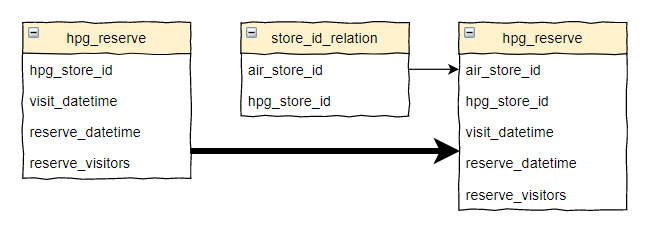

In [20]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [6]:
data

{'tra':                 air_store_id  visit_date  visitors
 0       air_ba937bf13d40fb24  2016-01-13        25
 1       air_ba937bf13d40fb24  2016-01-14        32
 2       air_ba937bf13d40fb24  2016-01-15        29
 3       air_ba937bf13d40fb24  2016-01-16        22
 4       air_ba937bf13d40fb24  2016-01-18         6
 ...                      ...         ...       ...
 252103  air_24e8414b9b07decb  2017-04-18         6
 252104  air_24e8414b9b07decb  2017-04-19         6
 252105  air_24e8414b9b07decb  2017-04-20         7
 252106  air_24e8414b9b07decb  2017-04-21         8
 252107  air_24e8414b9b07decb  2017-04-22         5
 
 [252108 rows x 3 columns],
 'as':              air_store_id         air_genre_name  \
 0    air_0f0cdeee6c9bf3d7         Italian/French   
 1    air_7cc17a324ae5c7dc         Italian/French   
 2    air_fee8dcf4d619598e         Italian/French   
 3    air_a17f0778617c76e2         Italian/French   
 4    air_83db5aff8f50478e         Italian/French   
 ..            

## 1. air/hpq_reserve 테이블
- info( ... ) method로 살펴본 결과 날짜형인 visit_datetime과 reverse_datetime이 object로 되어 있음
- datetime 라이브러리를 이용해 전처리 해주기로 함
  1. datetime형 자료를 변환 후 date(YYYY-MM-DD)만 추리기
  2. 새로운 feature인 reserve_datetime_diff 생성
  3. groupby로 air_store_id, visit_date, rs_sum, rv_sum, rs_mean, rv_mean 꼴로 테이블을 형성한다. [회고] groupby의 사용법을 확실하게 이해할 수 있었다
  
  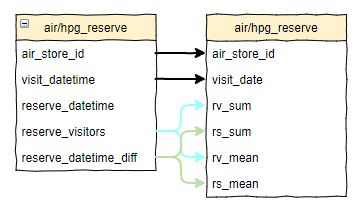
- 참고자료: [[파이썬 datetime] 일자와 시간(dt) 처리법](https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221603462366&proxyReferer=https:%2F%2Fwww.google.com%2F)

In [16]:
print(data['ar'].info())
print(data['hr'].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   hpg_store_id      object
 1   visit_datetime    object
 2   reserve_datetime  object
 3   reserve_visitors  int64 
dtypes: int64(1), object(3)
memory usage: 61.0+ MB
None


In [22]:
#TEST
data['hr']

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926
...,...,...,...,...,...
28178,hpg_0f78ef8d1e4b23d8,2017-04-01 21:00:00,2017-03-10 20:00:00,2,air_84f6876ff7e83ae7
28179,hpg_0f78ef8d1e4b23d8,2017-04-02 17:00:00,2017-04-02 14:00:00,2,air_84f6876ff7e83ae7
28180,hpg_0f78ef8d1e4b23d8,2017-04-08 19:00:00,2017-04-03 12:00:00,3,air_84f6876ff7e83ae7
28181,hpg_0f78ef8d1e4b23d8,2017-04-08 20:00:00,2017-03-09 07:00:00,4,air_84f6876ff7e83ae7


In [26]:
#TEST
data['hr'].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum()
# .rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    

,air_store_id,visit_datetime,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5
...,...,...,...,...
18615,air_fea5dc9594450608,2017-04-21,2,2
18616,air_fea5dc9594450608,2017-04-22,0,2
18617,air_fea5dc9594450608,2017-04-25,9,2
18618,air_fea5dc9594450608,2017-04-28,29,3


In [24]:
for df in ['ar','hr']:
    #YYYY-MM-DD
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    
    #Feature Engineering: 방문하기까지 며칠이 걸렸을까
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)

    #air/hpg_reserve를 다시 만들어준다
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_sum', 'reserve_visitors':'rv_sum'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_mean', 'reserve_visitors':'rv_mean'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [8]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [9]:
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [10]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [11]:
#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

In [12]:
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [13]:
# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [14]:
# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

In [15]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [16]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

In [17]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)

In [18]:
model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
model3.fit(train[col], np.log1p(train['visitors'].values))

preds1 = model1.predict(train[col])
preds2 = model2.predict(train[col])
preds3 = model3.predict(train[col])

In [19]:
print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
preds1 = model1.predict(test[col])
preds2 = model2.predict(test[col])
preds3 = model3.predict(test[col])

RMSE GradientBoostingRegressor:  0.3480211759737828
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.22942718047017202


In [20]:
test['visitors'] = 0.3*preds1+0.3*preds2+0.4*preds3
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
del train; del data;

In [21]:
# from hklee
# https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../input/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

NameError: name 'date_info' is not defined

In [ ]:
sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

In [ ]:
missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

In [ ]:
sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

sub_merge['visitors'] = 0.7*sub_merge['visitors_x'] + 0.3*sub_merge['visitors_y']* 1.1
sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)